## Gabriella Hoover, Michael Robinson
## CSC 583 NLP, Section 901
## 10 June 2024
## Final Project


Source - Much of the code for the multitask head came from the tutorial you provided: https://colab.research.google.com/github/zphang/zphang.github.io/blob/master/files/notebooks/Multi_task_Training_with_Transformers_NLP.ipynb

In [1]:
# Installations
!pip install torch nlp==0.2.0 datasets evaluate accelerate -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 901.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.1/857.1 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.

In [2]:
# Libraries

# Torch
import torch
from torch import nn
from torch import optim
from torch.utils.data.dataloader import DataLoader
from transformers.data.data_collator import DataCollator, InputDataClass
from torch.utils.data import Dataset as DS
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler

# Transformers and data
import transformers
from transformers import modeling_outputs
from transformers.data.data_collator import DataCollator
from transformers import DefaultDataCollator
import nlp
from datasets import Dataset
import dataclasses

# Math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Misc
import csv
import logging
from typing import List, Union, Dict

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Global vars
dev = torch.device("cuda")
max_length = 128

In [4]:
# Set seed
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

### Build multi-task transformer

In [5]:
# This class is used to make the models
class MultitaskModel(transformers.PreTrainedModel):
    def __init__(self, encoder, taskmodels_dict):
        """
        Setting MultitaskModel up as a PretrainedModel allows us
        to take better advantage of Trainer features
        """
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)
        self.sigmoid = nn.Sigmoid()

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict):
        """
        This creates a MultitaskModel using the model class and config objects
        from single-task models.

        We do this by creating each single-task model, and having them share
        the same encoder transformer.
        """
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name,
                config=model_config_dict[task_name],
            )
            if shared_encoder is None:
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model
        return cls(encoder=shared_encoder, taskmodels_dict=taskmodels_dict)

    @classmethod
    def get_encoder_attr_name(cls, model):
        """
        The encoder transformer is named differently in each model "architecture".
        This method lets us get the name of the encoder attribute
        """
        model_class_name = model.__class__.__name__
        if model_class_name.startswith("Bert"):
            return "bert"
        elif model_class_name.startswith("Roberta"):
            return "roberta"
        elif model_class_name.startswith("Albert"):
            return "albert"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    def forward(self, task_name, **kwargs):
        outputs = self.taskmodels_dict[task_name](**kwargs)
        logits = outputs.logits

        #apply sigmoid and scale to get 0-7
        scaled_logits = (self.sigmoid(logits) * 6) + 1
        return modeling_outputs.SequenceClassifierOutput(
            loss=outputs.loss,
            logits=scaled_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [6]:
# Makes model instance
def make_model(model_name):
  multitask_model = MultitaskModel.create(
  model_name=model_name,
  model_type_dict={
      "empathy": transformers.AutoModelForSequenceClassification,
      "distress": transformers.AutoModelForSequenceClassification
  },
  model_config_dict={
      "empathy": transformers.AutoConfig.from_pretrained(model_name, num_labels=1),
      "distress": transformers.AutoConfig.from_pretrained(model_name, num_labels=1)
  },
  )
  return multitask_model

### Tokenizer

In [7]:
# Empathy
def convert_to_empathy_features(example_batch):
    inputs = [essay for essay in example_batch['person_essay']]
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["person_empathy"]
    return features

# Distress
def convert_to_distress_features(example_batch):
    inputs = [essay for essay in example_batch['person_essay']]
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["person_distress"]
    return features


### Dataset

In [8]:
# Three function dicts:
# convert func dict for tokenizing,
# columns dict for getting the correct inputs,
# features dict is the tokenized columns (using the two dicts above)
def make_dicts():
  convert_func_dict = {
    "empathy": convert_to_empathy_features,
    "distress": convert_to_distress_features
  }

  columns_dict = {
    "empathy": ['input_ids', 'attention_mask', 'labels'],
    "distress": ['input_ids', 'attention_mask', 'labels']
  }

  features_dict = {}
  for task_name, dataset in dataset_dict.items():
      features_dict[task_name] = {}
      features_dict[task_name]['train'] = dataset.map(
              convert_func_dict[task_name],
              batched=True,
              load_from_cache_file=False,
          )
      print(task_name, len(dataset), len(features_dict[task_name]['train']))
      features_dict[task_name]['train'].set_format(
              type="torch",
              columns=columns_dict[task_name],
          )
  return convert_func_dict, columns_dict, features_dict

### Prediction

In [9]:
# Making predictions for test set
def predict_test(test_ds, multitask_model, test_ids):
  tokenized_test = test_ds.map(convert_to_test_features, batched=True)
  prediction_dict = {}
  dev = torch.device("cuda")
  for index, id in enumerate(test_ids):
    first_input_id = torch.unsqueeze(torch.tensor(tokenized_test['input_ids'][index], device=dev), dim=0)
    first_att_mask = torch.unsqueeze(torch.tensor(tokenized_test['attention_mask'][index], device=dev), dim=0)

    e = multitask_model('empathy', input_ids=first_input_id, attention_mask=first_att_mask).logits.item()
    d = multitask_model('distress', input_ids=first_input_id, attention_mask=first_att_mask).logits.item()
    prediction_dict[str(id)] = [e, d]
  return prediction_dict

In [10]:
# Making predictions for training set
def predict_train(tokenized_train, multitask_model):
  train_prediction = []
  dev = torch.device("cuda")
  for index in range (0,len(tokenized_train['empathy']['input_ids'])):
    first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
    first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)

    e = multitask_model('empathy', input_ids=first_input_id, attention_mask=first_att_mask).logits.item()
    d = multitask_model('distress', input_ids=first_input_id, attention_mask=first_att_mask).logits.item()
    train_prediction.append([e, d])
  return train_prediction

### Error Analysis

In [61]:
#function to iterate over predicted labels and actual labels and store the indices of the ones which we consider to be far away from the "gold standard"
#returns lists of indicesv of poor predictions for empathy and distress
def train_instance_diff(train_predictions, train_dataset, diff=4):
  emp_array = np.array(train_dataset['empathy']['labels'])
  dis_array = np.array(train_dataset['distress']['labels'])
  poor_emp_indices = []
  poor_dis_indices = []
  for i in range(0, len(train_predictions)):
    emp_diff = np.abs(emp_array[i] - train_predictions[i][0])
    dis_diff = np.abs(dis_array[i]- train_predictions[i][1])
    if emp_diff >= diff:
      poor_emp_indices.append(i)
    if dis_diff >= diff:
      poor_dis_indices.append(i)
  return poor_emp_indices, poor_dis_indices

In [12]:
#function to display poor predictions of empathy and distress
def compare_results(emp_index, dis_index, train_dataset, train_predictions):
  essay_array = np.array(train_dataset['empathy']['person_essay'])
  emp_array = np.array(train_dataset['empathy']['labels'])
  dis_array = np.array(train_dataset['distress']['labels'])
  print(essay_array[emp_index])
  print("----------EMPATHY----------")
  print("Actual label: " + str(emp_array[emp_index]))
  print("Predicted label: " + str(train_predictions[emp_index][0]) + "\n")
  print(essay_array[dis_index])
  print("----------DISTRESS----------")
  print("Actual label: " + str(dis_array[dis_index]))
  print("Predicted label: " + str(train_predictions[dis_index][1]))

### Load in dataset

In [13]:
train_df = pd.read_csv('/content/drive/My Drive/train.tsv', sep='\t')
train_df.head()

,conversation_id,article_id,person_id,person_essay,person_empathy,person_distress
0,295,242,p029,"Wow, this is very sad. All these poor people ...",2.000000,1.000000
1,173,400,p041,The article lacks clarity on whether Isbindi w...,2.428571,1.000000
2,469,326,p068,I feel for anyone feeling targeted or unsafe u...,6.000000,6.000000
3,342,186,p024,This angers me to know stuff like this still g...,5.571429,5.857143
4,86,304,p030,I just read an article about suicides in child...,4.428571,4.000000


In [14]:
test_df = pd.read_csv('/content/drive/My Drive/test.tsv', sep='\t')
test_df.head()

,id,conversation_id,article_id,person_id,person_essay
0,1,356,44,p068,This was just so sad and senseless. The brutal...
1,2,344,186,p068,This article was a little hard for me to follo...
2,3,487,395,p010,This story is very very sad. it seems almost...
3,4,487,395,p035,"I know that the cousin said not to judge Mark,..."
4,5,420,301,p068,This article was so disturbing to read through...


In [15]:
test_ids = test_df['id']
test_ids.head()

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: int64

In [16]:
# Dataset modifying
logging.basicConfig(level=logging.INFO)
train_empathy = train_df.drop(['person_distress'], axis=1)
train_empathy_ds = Dataset.from_pandas(train_empathy)
train_distress = train_df.drop(['person_empathy'], axis=1)
train_distress_ds = Dataset.from_pandas(train_distress)
test_ds = Dataset.from_pandas(test_df)
dataset_dict = {
    "empathy": train_empathy_ds,
    "distress": train_distress_ds
}

### Data analysis

In [17]:
train_df.columns

Index(['conversation_id', 'article_id', 'person_id', 'person_essay',
       'person_empathy', 'person_distress'],
      dtype='object')

In [18]:
train_df['person_empathy'].describe()

count    863.000000
mean       4.243696
std        1.859745
min        1.000000
25%        2.714286
50%        4.428571
75%        6.000000
max        7.000000
Name: person_empathy, dtype: float64

In [19]:
train_df['person_distress'].describe()

count    863.000000
mean       3.817311
std        2.025454
min        1.000000
25%        1.857143
50%        3.857143
75%        5.857143
max        7.000000
Name: person_distress, dtype: float64

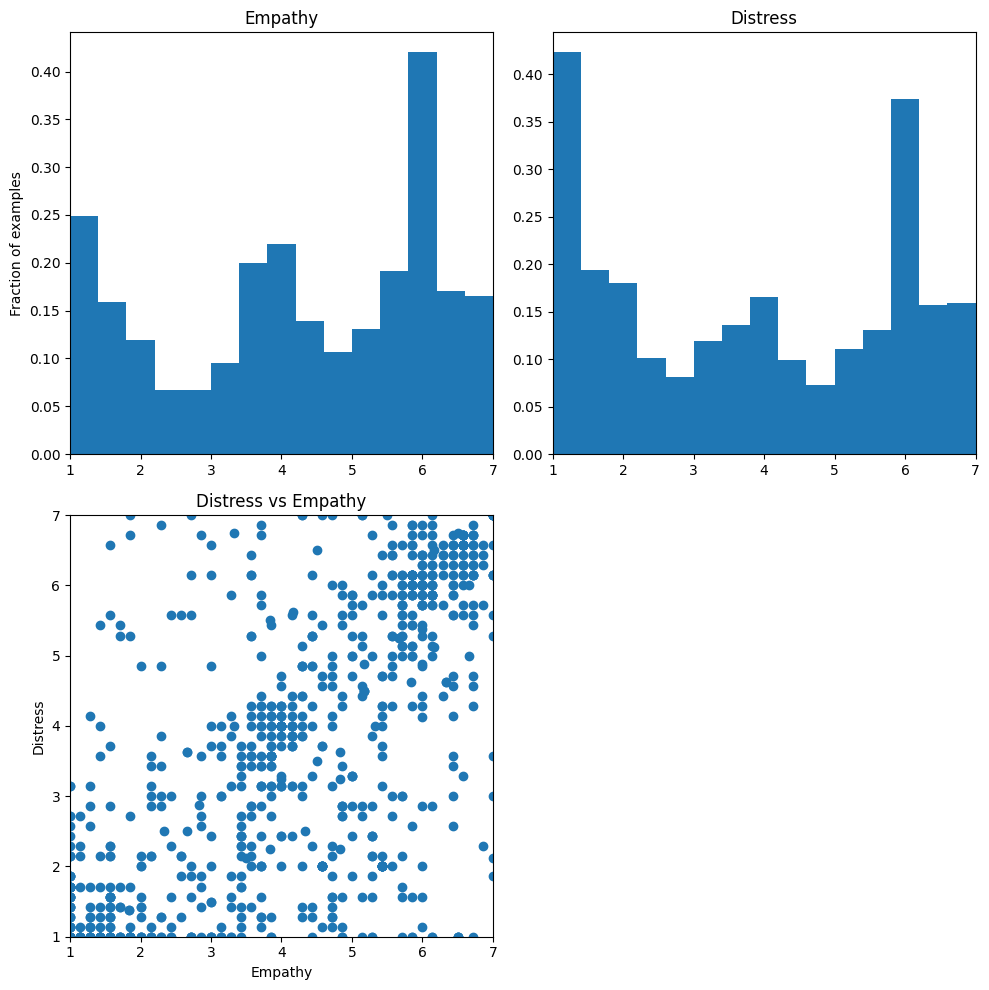

In [20]:
# Making histograms of labels and a scatter plot of them
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
ax00.set(title="Empathy", ylabel="Fraction of examples", xlim=(1, 7))
ax01.set(title="Distress", xlim=(1, 7))
ax10.set(title="Distress vs Empathy", xlabel="Empathy", ylabel="Distress", xlim=(1, 7), ylim=(1, 7))
fig.delaxes(ax11)

ax00.hist(train_df['person_empathy'], density=True, bins=15)
ax01.hist(train_df['person_distress'], density=True, bins=15)

ax10.scatter(train_df['person_empathy'], train_df['person_distress'])

plt.tight_layout()
plt.show()

### Dataloader

In [21]:
class StrIgnoreDevice(str):
    """
    This is a hack. The Trainer is going call .to(device) on every input
    value, but we need to pass in an additional `task_name` string.
    This prevents it from throwing an error
    """
    def to(self, device):
        return self

In [22]:
class DataLoaderWithTaskname:
    """
    Wrapper around a DataLoader to also yield a task name
    """
    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)

    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


In [23]:
class MultitaskDataloader:
    """
    Data loader that combines and samples from multiple single-task
    data loaders.
    """
    def __init__(self, dataloader_dict):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader)
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset)
            for dataloader in self.dataloader_dict.values()
        )

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):
        """
        For each batch, sample a task, and yield a batch from the respective
        task Dataloader.

        We use size-proportional sampling, but you could easily modify this
        to sample from some-other distribution.
        """
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader)
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])


### Trainer

In [24]:
class MultitaskTrainer(transformers.Trainer):
    def get_single_train_dataloader(self, task_name, train_dataset):
        """
        Create a single-task data loader that also yields task names
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        train_sampler = (
                RandomSampler(train_dataset)
            )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              train_dataset,
              batch_size=self.args.train_batch_size,
              sampler=train_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )
        return data_loader

    def get_train_dataloader(self):
        """
        Returns a MultitaskDataloader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each
        task Dataloader
        """
        return MultitaskDataloader({
            task_name: self.get_single_train_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.train_dataset.items()
        })


In [25]:
class NLPDataCollator(DefaultDataCollator):
    """
    Extending the existing DataCollator to work with NLP dataset batches
    """
    def collate_batch(self, features: List[Union[InputDataClass, Dict]]) -> Dict[str, torch.Tensor]:
        first = features[0]
        if isinstance(first, dict):
          # NLP data sets current works presents features as lists of dictionary
          # (one per example), so we  will adapt the collate_batch logic for that
          if "labels" in first and first["labels"] is not None:
              if first["labels"].dtype == torch.int64:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
              else:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              batch = {"labels": labels}
          for k, v in first.items():
              if k != "labels" and v is not None and not isinstance(v, str):
                  batch[k] = torch.stack([f[k] for f in features])
          return batch
        else:
          # otherwise, revert to using the default collate_batch
          return DefaultDataCollator().collate_batch(features)

### Roberta Model

In [ ]:
model_name = "roberta-base"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
convert_func_dict, columns_dict, features_dict = make_dicts()
train_dataset = {
    task_name: dataset["train"]
    for task_name, dataset in features_dict.items()
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [30]:
# Defining training parameters
training_args = transformers.TrainingArguments(
        output_dir="./models/multitask_model",
        overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        save_steps=3000,
        logging_steps=648 // 3
    )

In [ ]:


# Train the model
trainer = MultitaskTrainer(
    model=multitask_model,
    args=training_args,
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
history = trainer.train()

Step,Training Loss
216,5.539700
432,2.416600
648,1.839100


In [ ]:
history

TrainOutput(global_step=648, training_loss=3.265116420792945, metrics={'train_runtime': 143.3973, 'train_samples_per_second': 36.109, 'train_steps_per_second': 4.519, 'total_flos': 342945870732288.0, 'train_loss': 3.265116420792945, 'epoch': 3.0})

Prediction time

In [26]:
# Tokenizing test features
def convert_to_test_features(example_batch):
    inputs = example_batch['person_essay']
    features = tokenizer(
        inputs,
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    return features

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Output to csv file

In [27]:
def write_to_csv(prediction_dict, filename):
  header = ['id','person_empathy','person_distress']
  with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(header)

    for key, values in prediction_dict.items():
        writer.writerow([key] + values)


In [ ]:
write_to_csv(prediction_dict, 'predictions1.csv')

Get training predictions for error analysis

For our error analysis, we are considering any prediction that has a difference of >=4 with the ground truth label to be far away from the "gold standard"

In [ ]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-34-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-34-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [ ]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset)

In [ ]:
#grab first instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[0], poor_dis[0], train_dataset, train_predictions)

Wow, this is very sad.  All these poor people who lost their lives because of this ongoing conflict.  I must say, this whole area just constantly seems caught up in some terrible conflict, tension, war, and violence.  I don't understand what is going on over there, but I know it is very sad to hear about innocent people being killed as a result.  I also feel sad for the U.S. Soldiers who lost their lives.  Their families must be grieving terribly.  So the whole thing is a tragedy, and it all just seems so unnecesary to me.  All this senseless killing.
----------EMPATHY----------
Actual label: 2.0
Predicted label: 6.261630058288574

Wow, this is very sad.  All these poor people who lost their lives because of this ongoing conflict.  I must say, this whole area just constantly seems caught up in some terrible conflict, tension, war, and violence.  I don't understand what is going on over there, but I know it is very sad to hear about innocent people being killed as a result.  I also feel

### Albert Base Model

**Try a different pretrained model in our multitask class**

---



In [31]:
# Setting up Albert model
model_name = "albert/albert-base-v2"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

convert_func_dict, columns_dict, features_dict = make_dicts()
train_dataset = {
    task_name: dataset["train"]
    for task_name, dataset in features_dict.items()
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [32]:
# train
trainer = MultitaskTrainer(
    model=multitask_model,
    args=training_args,
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
trainer.train()

Step,Training Loss
216,4.457200
432,2.216500
648,1.492200


TrainOutput(global_step=648, training_loss=2.7219483646345726, metrics={'train_runtime': 118.2856, 'train_samples_per_second': 43.775, 'train_steps_per_second': 5.478, 'total_flos': 30936092728320.0, 'train_loss': 2.7219483646345726, 'epoch': 3.0})

prediction time

In [ ]:
tokenized_test = test_ds.map(convert_to_test_features, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

In [ ]:
write_to_csv(prediction_dict, 'predictions_model2.csv')

Training predictions error analysis

In [33]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [34]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset)

In [35]:
#grab first instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[1], poor_dis[1], train_dataset, train_predictions)

The article lacks clarity on whether Isbindi was a child or a rhino. I am more than a little confused. I have neutral feelings toward the story as it was presented. Any loss of life is tragic, but more so when it is an innocent and defenseless child. I was also quite curious as what exactly was the cause of death.
----------EMPATHY----------
Actual label: 2.4285715
Predicted label: 6.645351886749268

The article lacks clarity on whether Isbindi was a child or a rhino. I am more than a little confused. I have neutral feelings toward the story as it was presented. Any loss of life is tragic, but more so when it is an innocent and defenseless child. I was also quite curious as what exactly was the cause of death.
----------DISTRESS----------
Actual label: 1.0
Predicted label: 5.961671352386475


### Bert Base Uncased Model

In [36]:
# Bert model
model_name = "google-bert/bert-base-uncased"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
convert_func_dict, columns_dict, features_dict = make_dicts()
train_dataset = {
    task_name: dataset["train"]
    for task_name, dataset in features_dict.items()
}

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [37]:
# train
trainer = MultitaskTrainer(
    model=multitask_model,
    args=training_args,
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
trainer.train()

Step,Training Loss
216,7.094100
432,3.224500
648,2.430100


TrainOutput(global_step=648, training_loss=4.249582832242235, metrics={'train_runtime': 127.0569, 'train_samples_per_second': 40.753, 'train_steps_per_second': 5.1, 'total_flos': 340597261163520.0, 'train_loss': 4.249582832242235, 'epoch': 3.0})

Prediction time

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

In [ ]:
write_to_csv(prediction_dict, 'predictions_model3.csv')

Training Predictions Error Analysis

In [38]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [39]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset)

In [40]:
#grab first instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[2], poor_dis[2], train_dataset, train_predictions)

After reading the article, you can't help but feel bad for all the Muslims that are currently living in America. You feel bad for them because of what they are going through and all the discrimination they are facing. It's unfair that the ones that are innocent are being stereotyped as well and lumped into the same group as the terrorists when not everyone is like that.
----------EMPATHY----------
Actual label: 1.4285715
Predicted label: 6.469432830810547

After reading the article, you can't help but feel bad for all the Muslims that are currently living in America. You feel bad for them because of what they are going through and all the discrimination they are facing. It's unfair that the ones that are innocent are being stereotyped as well and lumped into the same group as the terrorists when not everyone is like that.
----------DISTRESS----------
Actual label: 1.0
Predicted label: 6.049743175506592


### Bert Large Cased
trying a different Bert to compare

In [41]:
# Bert cased
model_name = "google-bert/bert-large-cased"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

convert_func_dict, columns_dict, features_dict = make_dicts()
train_dataset = {
    task_name: dataset["train"]
    for task_name, dataset in features_dict.items()
}

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [42]:
# train
trainer = MultitaskTrainer(
    model=multitask_model,
    args=training_args,
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
trainer.train()

Step,Training Loss
216,5.981300
432,2.033600
648,1.306700


TrainOutput(global_step=648, training_loss=3.1072230868869357, metrics={'train_runtime': 443.2457, 'train_samples_per_second': 11.682, 'train_steps_per_second': 1.462, 'total_flos': 1206385149828096.0, 'train_loss': 3.1072230868869357, 'epoch': 3.0})

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)
write_to_csv(prediction_dict, 'predictions_model4.csv')

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training predictions error analysis

In [43]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [44]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset)

In [45]:
#grab first instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[3], poor_dis[3], train_dataset, train_predictions)

That's awful, I feel that Oklahoma City might not be as safe as I thought. After 9/11 they raised security around airplanes a lot, but it hasn't been perfect. They probably can never get it perfect. I guess it wasn't terrorism exactly though? Just a regular murder. That's just awful either way. There should definitely be a thorough investigation.
----------EMPATHY----------
Actual label: 1.4285715
Predicted label: 6.210355758666992

This whole situation kind of blows.  On one hand, I hate that what we might be doing is infringing on people sacred land.  On the other hand, I remember reading about how they gave the pipeline an x amount chance of spilling into the water, and it was relatively low.  I just don't know who I support here.  I don't think people should be burning cars, and blocking roads, but I don't really have an alternative plan either.
----------DISTRESS----------
Actual label: 1.1428572
Predicted label: 5.620267391204834


## Pearson Loss

### Roberta with Pearson

In [46]:
# Now we'll use the average value of the pearson coefficient of empathy and distress
model_name = "roberta-base"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
_, _, features_dict = make_dicts()

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [47]:
# PyTorch dataset
class CustomTrainingDataset(DS):
  def __init__(self, features_dict):
    super().__init__()
    self.ids = features_dict["empathy"]["train"]["input_ids"]
    self.masks = features_dict["empathy"]["train"]["attention_mask"]
    self.emp_labels = features_dict["empathy"]["train"]["labels"]
    self.dis_labels = features_dict["distress"]["train"]["labels"]

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    return self.ids[idx], self.masks[idx], self.emp_labels[idx], self.dis_labels[idx]

custom_train_dataset = CustomTrainingDataset(features_dict)

In [48]:
# Loss function
def avg_pearson_loss(dev, emp_pred, emp_lab, dis_pred, dis_lab):
  emp = torch.stack((emp_pred, emp_lab.to(dev)))
  dis = torch.stack((dis_pred, dis_lab.to(dev)))
  return (torch.corrcoef(emp)[0, 1] + torch.corrcoef(dis)[0, 1]) / 2

In [49]:
# Setting up model
optimizer = optim.AdamW(multitask_model.parameters(), lr=1e-4, maximize=True)
criterion = avg_pearson_loss
multitask_model = multitask_model.to(dev)


In [50]:
# Training function
def custom_train(custom_train_dataset, dev, optimizer, criterion, batch_size=8, epochs=1, shuffle=True):
  train_dataloader = DataLoader(custom_train_dataset, shuffle=shuffle, batch_size=batch_size)
  epoch_losses = []
  batch_losses = []
  for i in range(epochs):
    temp_losses = []
    for ids, masks, emp_labs, dis_labs in train_dataloader:
      emp_preds = multitask_model('empathy', input_ids=ids.to(dev), attention_mask=masks.to(dev))
      dis_preds = multitask_model('distress', input_ids=ids.to(dev), attention_mask=masks.to(dev))
      loss = criterion(dev, torch.squeeze(emp_preds.logits), emp_labs, torch.squeeze(dis_preds.logits), dis_labs)
      temp_losses.append(loss)
      batch_losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    epoch_losses.append(np.mean(np.array(torch.tensor(temp_losses).cpu())))
  return batch_losses, epoch_losses


In [51]:
# Training
batch_losses, epoch_losses = custom_train(custom_train_dataset, dev, optimizer, criterion, batch_size=8, epochs=3, shuffle=True)

In [52]:
# Plotting
def plot_training(batch_losses, epoch_losses):
  batch_losses = np.array(torch.tensor(batch_losses).cpu())
  epoch_losses = np.array(epoch_losses)
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 6), sharey=False)

  ax0.set(xlabel="batch number", title="Average r")
  ax1.set(xlabel="epoch number", title="Average r")
  ax0.plot(np.arange(batch_losses.shape[0]), batch_losses)
  ax1.plot(np.arange(epoch_losses.shape[0]), epoch_losses)
  fig.suptitle("Training")
  plt.show()

In [ ]:
print("Average loss per epoch is: ")

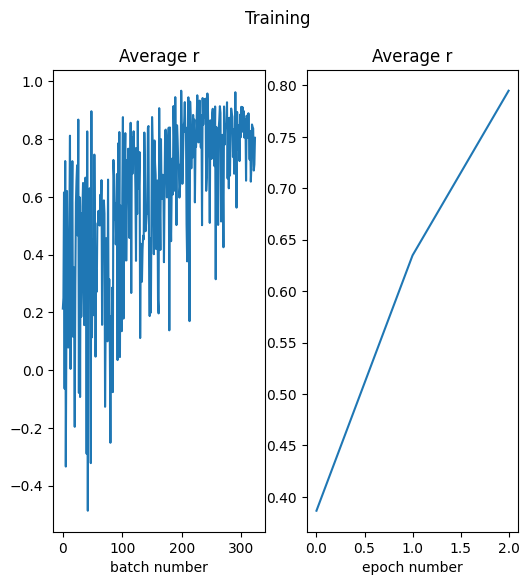

In [ ]:
plot_training(batch_losses, epoch_losses)

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
write_to_csv(prediction_dict, 'predictions_model5.csv')

Training prediction error analysis

For our models that implemented Pearson Correlation Coefficient, we lowered the distance value that we considered to be of poor quality because not all of our models had predictions with a difference of >=4. For these models, we are considering a difference of >=3 to be poor.

In [53]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [62]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset, diff=3)

In [65]:
#grab first instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[4], poor_dis[4], train_dataset, train_predictions)

After reading the article, i couldn't help but feel disturbed at the fact that humans can do things like this to animals. Humans should be more aware of what they are doing and the fact that they can harm animals unintentionally. Humans should do more to help other living things on Earth because we are not the only things living here.
----------EMPATHY----------
Actual label: 1.5714285
Predicted label: 4.781175136566162

I can barely believe that the events in that article were real. Such barbaric actions by ISIS...I feel so badly for the people who are forced to live side by side with such brutal people. I can understand why people are fleeing the area by the thousands. ISIS could basically kill you for any reason and likely wouldn't be challenged for their actions. This is such a disgrace. 
----------DISTRESS----------
Actual label: 7.0
Predicted label: 3.9152491092681885


## Pearson with Albert Multitask

In [66]:
# Set up model
model_name = "albert/albert-base-v2"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
_, _, features_dict = make_dicts()
custom_train_dataset = CustomTrainingDataset(features_dict)
optimizer = optim.AdamW(multitask_model.parameters(), lr=1e-4, maximize=True)
multitask_model = multitask_model.to(dev)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [67]:
# Training
batch_losses, epoch_losses = custom_train(custom_train_dataset, dev, optimizer, criterion, batch_size=8, epochs=3, shuffle=True)

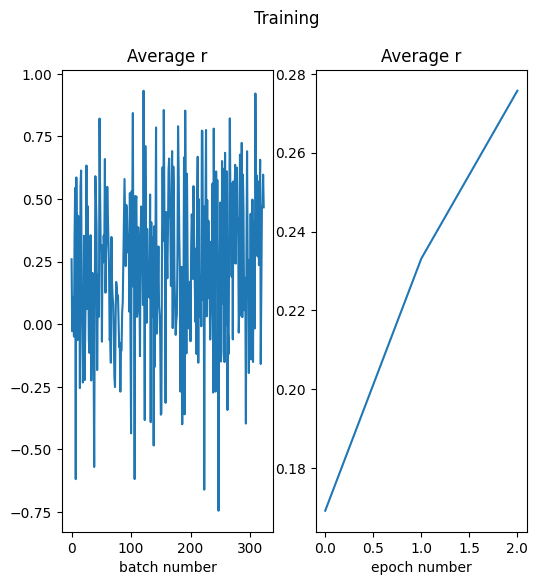

In [68]:
# Plotting
plot_training(batch_losses, epoch_losses)

Prediction time

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
write_to_csv(prediction_dict, 'predictions_model6.csv')

Training prediction error analysis

In [69]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [70]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset, diff=3)

In [71]:
#grab instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[5], poor_dis[5], train_dataset, train_predictions)

i cant believe stuff like this is going on. I mean you would think our society would be better by now. I feel like we as a society are getting worse in some ways, although in others we are improving, but still. What can be done? How can we improve? This is just par for the course at this point. I'm not even sure what to say about it.
----------EMPATHY----------
Actual label: 1.2857143
Predicted label: 4.357679843902588

Why would people go to Norway to mess with the polar bears? I do not understand what people are thinking sometimes. I wish people would just leave the polar bears and other animals alone for they can live their life just as people live their life. I hope one day the population of polar bears comes back up to normal.
----------DISTRESS----------
Actual label: 6.714286
Predicted label: 3.4834790229797363


## Pearson with Bert Base Uncased Multitask

In [83]:
# Another model using Pearson as loss
model_name = "google-bert/bert-base-uncased"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
_, _, features_dict = make_dicts()
custom_train_dataset = CustomTrainingDataset(features_dict)
optimizer = optim.AdamW(multitask_model.parameters(), lr=1e-4, maximize=True)
multitask_model = multitask_model.to(dev)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [84]:
# Training
batch_losses, epoch_losses = custom_train(custom_train_dataset, dev, optimizer, criterion, batch_size=8, epochs=3, shuffle=True)

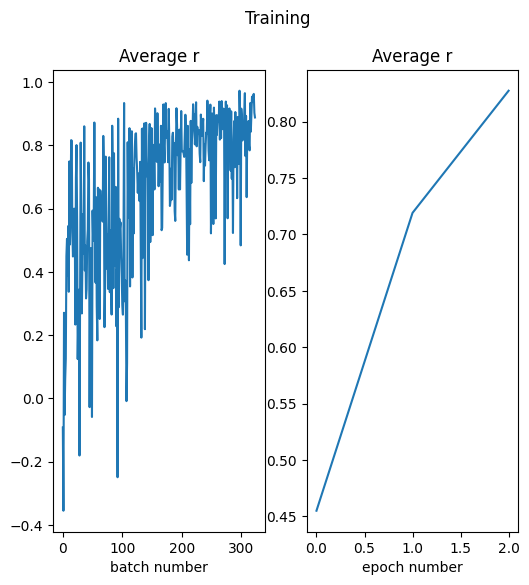

In [74]:
# Plotting
plot_training(batch_losses, epoch_losses)

Prediction time

In [85]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
write_to_csv(prediction_dict, 'predictions_model7.csv')

Training prediction error analysis

In [86]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [87]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset, diff=3)

In [88]:
#grab instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[6], poor_dis[6], train_dataset, train_predictions)

After reading the article, i felt really bad for the wolf and animals that get hunted in general. I think that there should definitely be some sort of punishment for people who decide to kill animals, especially endangered species of animals just for fun. I think it is so inhumane and twisted that someone can kill a beautiful animal like that with no type of remorse whatsoever.
----------EMPATHY----------
Actual label: 1.0
Predicted label: 4.228018760681152

I just read an article about a man who was given everything in life, literally. A deluxe apartment, a great job and a position of status in New York society were apparently not enough for him. He was involved in the brutal murder of a man because the man refused his sexual advances. He must suffer from some sort of mental deficiency. 
----------DISTRESS----------
Actual label: 1.1428572
Predicted label: 4.247422218322754


## Pearson with Bert Large Cased Multitask

In [89]:
# Model set up
model_name = "google-bert/bert-large-cased"
multitask_model = make_model(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
_, _, features_dict = make_dicts()
custom_train_dataset = CustomTrainingDataset(features_dict)
optimizer = optim.AdamW(multitask_model.parameters(), lr=1e-4, maximize=True)
multitask_model = multitask_model.to(dev)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


empathy 863 863


Map:   0%|          | 0/863 [00:00<?, ? examples/s]

distress 863 863


In [90]:
# Training
batch_losses, epoch_losses = custom_train(custom_train_dataset, dev, optimizer, criterion, batch_size=8, epochs=3, shuffle=True)

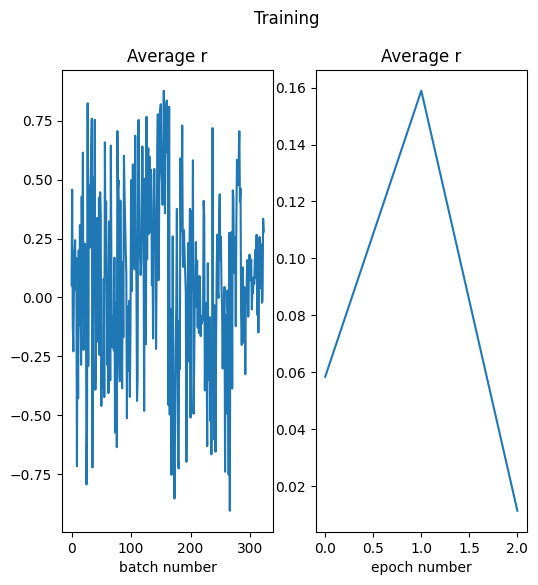

In [ ]:
# Plotting
plot_training(batch_losses, epoch_losses)

In [ ]:
prediction_dict = predict_test(test_ds, multitask_model, test_ids)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
write_to_csv(prediction_dict, 'predictions_model8.csv')

Training prediction error analysis

In [91]:
train_predictions= predict_train(train_dataset, multitask_model)

<ipython-input-10-aec3b225cfc2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_input_id = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['input_ids'][index], device=dev), dim=0)
<ipython-input-10-aec3b225cfc2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_att_mask = torch.unsqueeze(torch.tensor(tokenized_train['empathy']['attention_mask'][index], device=dev), dim=0)


In [92]:
poor_emp, poor_dis = train_instance_diff(train_predictions, train_dataset, diff=3)

In [93]:
#grab instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[7], poor_dis[7], train_dataset, train_predictions)

I think it must be investigated thoroughly and if true this man should be removed from his position immediately. Groping is just as bad as rape in my honest and humble opinion and should be removed fast. I think a precedent has to be set to stop these things and in order for that to happen we must be able to iron the bad ones out.
----------EMPATHY----------
Actual label: 6.0
Predicted label: 1.9952391386032104

My heart goes out to these poor kids-they are just innocent pawns in this terrible world of war, injustice and corruption. Shame on French authorities for putting them in such awful conditions. However, immigration issue is another thing that needs to be considered here, we cannot help everyone, so, instead, we need to help them fix their own country instead of coming over somewhere else and suffering!
----------DISTRESS----------
Actual label: 7.0
Predicted label: 3.124765634536743


### #2: Use RNN

In [94]:
# Pretty basic bidirectional rnn
class RnnModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout, device):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, device=device, bidirectional=True)
    self.linear = nn.Linear(hidden_size * 2, 2)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x, _ = self.rnn(x)
    x = self.relu(x)
    x = self.linear(x)
    x = (6 * self.sigmoid(x)) + 1
    return x[:, 0], x[:, 1]


In [95]:
rnn = RnnModel(input_size=128,
               hidden_size=128,
               num_layers=10,
               dropout=0.5,
               device=dev)

In [96]:
# Adam optimizer with L1 regularization
rnn_optimizer = optim.AdamW(rnn.parameters(), lr=1e-4, maximize=True)
rnn = rnn.to(dev)

In [97]:
# Makes a dataloader, makes predictions and compares them to labels - backpropagates gradient and stores losses
def rnn_train(custom_train_dataset, dev, optimizer, criterion, batch_size=8, epochs=1, shuffle=True):
  train_dataloader = DataLoader(custom_train_dataset, shuffle=shuffle, batch_size=batch_size)
  epoch_losses = []
  batch_losses = []
  for i in range(epochs):
    temp_losses = []
    for ids, masks, emp_labs, dis_labs in train_dataloader:
      emp_preds, dis_preds = rnn(ids.to(torch.float32).to(dev))
      loss = criterion(dev, torch.squeeze(emp_preds), emp_labs, torch.squeeze(dis_preds), dis_labs)
      temp_losses.append(loss)
      batch_losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    epoch_losses.append(np.mean(np.array(torch.tensor(temp_losses).cpu())))
  return batch_losses, epoch_losses

In [98]:
batch_losses, epoch_losses = rnn_train(custom_train_dataset, dev, rnn_optimizer, criterion, batch_size=64, epochs=1000, shuffle=True)

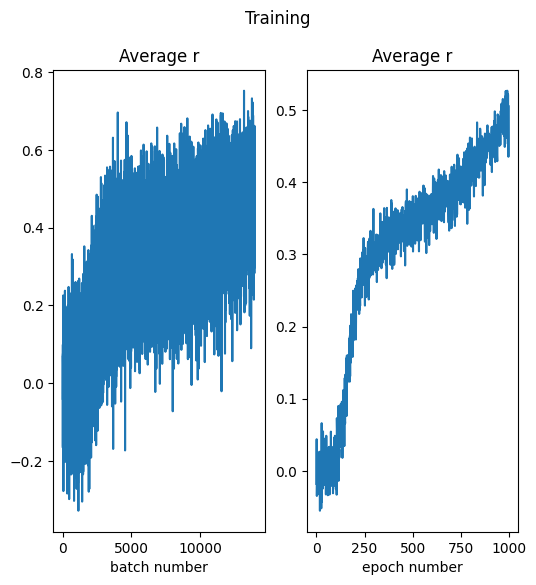

In [ ]:
# Plotting
plot_training(batch_losses, epoch_losses)

In [99]:
rnn.eval()

RnnModel(
  (rnn): RNN(128, 128, num_layers=10, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [100]:
#use a tokenizer from best model so far
model_name = "roberta-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenized_test = test_ds.map(convert_to_test_features, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
predictions = rnn.forward(torch.tensor(tokenized_test['input_ids'], dtype=torch.float32, device=dev))

In [ ]:
prediction_dict = {}
for index, id in enumerate(test_ids):
  e = predictions[0][index].item()
  d = predictions[1][index].item()
  prediction_dict[str(id)] = [e, d]

In [ ]:
write_to_csv(prediction_dict, 'predictions_model9.csv')

Training Error Analysis

In [101]:
train_predictions = rnn.forward(torch.tensor(train_dataset['empathy']['input_ids'], dtype=torch.float32, device=dev))

<ipython-input-101-fffb17a86be3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = rnn.forward(torch.tensor(train_dataset['empathy']['input_ids'], dtype=torch.float32, device=dev))


In [104]:
train_prediction_list = []
for index in range(0, len(train_df['person_essay'])):
  e = train_predictions[0][index].item()
  d = train_predictions[1][index].item()
  train_prediction_list.append([e, d])

In [105]:
poor_emp, poor_dis = train_instance_diff(train_prediction_list, train_dataset, diff=3)

In [111]:
#grab instance of poor predictions and compare them to the actual labels
compare_results(poor_emp[1], poor_dis[1], train_dataset, train_prediction_list)

This whole situation is alarming.  It's scary that such sick individuals exist out there that will commit such horrible crimes.  It makes me feel like the world is a scary and horrible place.  I'm not really sure what else to say about it.  I hope justice works and is brought against these people.  This type of thing should never happen and I feel bad for the victims and families involved.  
----------EMPATHY----------
Actual label: 2.2857144
Predicted label: 5.344865798950195

Did you see Shannon Doherty's interview about cancer? I related to so much of what she said, about letting go of who she thought she was supposed to be and also about how she would look at her husband and think how sorry she was. I know exactly how that feels. Who would have thought Brenda would still have an impact on me 25 years later.
----------DISTRESS----------
Actual label: 1.7142857
Predicted label: 4.908368110656738
